## Lab 3 - RecSys
### Gerard Santacatalina Rubio - 1534002



### 1. PySpark Initialization

In this cell we're going to initialize pyspark just like in the other notebooks we've worked on:

In [ ]:
import warnings
! pip install pyspark
! pip install seaborn scipy --upgrade

warnings.filterwarnings('ignore')

if not ("spark" in vars() or "spark" in globals()):
    from pyspark.sql import SparkSession
    spark = SparkSession.builder.appName("intro-to-mllib").master("local").getOrCreate()
else:
    print("SparkSession already configured!")

# To avoid breaks when showing tables with lot of columns
from IPython.core.display import HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


SparkSession already configured!


### 2. Load/Clean Data


Now, in order to load the data so that we can start cleaning it and seeing how it is distributed we need to create the spark dataframe first. Depending on the execution environment we're using we'll need to execute the following cell of code or the second one. Again, if we're using Collab we'll run the first one, otherwise the second:

In [ ]:
import os
covtype_csv_path = os.path.join("covtype", "covtype.csv")
covtype_df_s = spark.read.option("header", True).csv(covtype_csv_path, inferSchema=True)

Once we've created the Spark's Dataframe now we need to see the schema of this dataframe to see the type of the different attributes it contains:

In [ ]:
print("Houses - Schema")
covtype_df_s.printSchema()

Houses - Schema
root
 |-- Elevation: integer (nullable = true)
 |-- Aspect: integer (nullable = true)
 |-- Slope: integer (nullable = true)
 |-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
 |-- Vertical_Distance_To_Hydrology: integer (nullable = true)
 |-- Horizontal_Distance_To_Roadways: integer (nullable = true)
 |-- Hillshade_9am: integer (nullable = true)
 |-- Hillshade_Noon: integer (nullable = true)
 |-- Hillshade_3pm: integer (nullable = true)
 |-- Horizontal_Distance_To_Fire_Points: integer (nullable = true)
 |-- Wilderness_Area1: integer (nullable = true)
 |-- Wilderness_Area2: integer (nullable = true)
 |-- Wilderness_Area3: integer (nullable = true)
 |-- Wilderness_Area4: integer (nullable = true)
 |-- Soil_Type1: integer (nullable = true)
 |-- Soil_Type2: integer (nullable = true)
 |-- Soil_Type3: integer (nullable = true)
 |-- Soil_Type4: integer (nullable = true)
 |-- Soil_Type5: integer (nullable = true)
 |-- Soil_Type6: integer (nullable = true)
 |-- Soi

Now we want to see a little bit of information about these features, so we're going to use the summary function that allows us to get a glimpse of the nature of the data of these attributes:

In [ ]:
covtype_df_s.summary().show()

+-------+------------------+------------------+-----------------+--------------------------------+------------------------------+-------------------------------+------------------+------------------+------------------+----------------------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-----

We can clearly see that we've got 577.231 rows or observations and 55 columns or attributes, also called features.

In [ ]:
total = covtype_df_s.count()
print(f"No. Records: {total}")

print(f"No. Columns: {len(covtype_df_s.columns)}")

No. Records: 577231
No. Columns: 55


After seeing the distribution and main information about the features that this dataset contains we're now going to see whether we're dealing with NaNs or not. Normally the summary() function tells us if we have some non existant data in our dataframe since it can't compute the different statistics and most of the time we end up having nulls on the output of the summary function. 

We also have to keep in mind that infinite values could appear in our dataset, both positive and negative infinites. We'll simply convert these infinite values to NaNs and we'll get rid of these afterwards. 

We can clearly see that we haven't found NaN nor infinite values:

In [ ]:
from pyspark.sql.functions import isnan
import numpy as np

covtype_df_s.replace([np.inf, -np.inf], np.nan)

for c in covtype_df_s.columns:
    missing = covtype_df_s.filter(covtype_df_s[c].isNull() | isnan(covtype_df_s[c])).count()
    print(f"{c.ljust(20)} {str(missing).ljust(4)} -> {(missing/total)*100:.2f}%")

Elevation            0    -> 0.00%
Aspect               0    -> 0.00%
Slope                0    -> 0.00%
Horizontal_Distance_To_Hydrology 0    -> 0.00%
Vertical_Distance_To_Hydrology 0    -> 0.00%
Horizontal_Distance_To_Roadways 0    -> 0.00%
Hillshade_9am        0    -> 0.00%
Hillshade_Noon       0    -> 0.00%
Hillshade_3pm        0    -> 0.00%
Horizontal_Distance_To_Fire_Points 0    -> 0.00%
Wilderness_Area1     0    -> 0.00%
Wilderness_Area2     0    -> 0.00%
Wilderness_Area3     0    -> 0.00%
Wilderness_Area4     0    -> 0.00%
Soil_Type1           0    -> 0.00%
Soil_Type2           0    -> 0.00%
Soil_Type3           0    -> 0.00%
Soil_Type4           0    -> 0.00%
Soil_Type5           0    -> 0.00%
Soil_Type6           0    -> 0.00%
Soil_Type7           0    -> 0.00%
Soil_Type8           0    -> 0.00%
Soil_Type9           0    -> 0.00%
Soil_Type10          0    -> 0.00%
Soil_Type11          0    -> 0.00%
Soil_Type12          0    -> 0.00%
Soil_Type13          0    -> 0.00%
Soil_Typ

In the following cell we decide to create a pandas dataframe since it's actually easier for us to plot the data. We'll be also cleaning this pandas dataframe to show how we remove succesfully the outliers we encounter in this section.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
covtype_pandas = covtype_df_s.toPandas()

This scatterplot shows us that there are many points with a value equal to 0. This actually seems pretty weird and doesn't make too much sense so we're going to remove them from out data. We'll filter out all those values with a 0 in the Hillshade_3pm column and the values under 120 for Hillshade_Noon because the vast majority of the points are above this value.

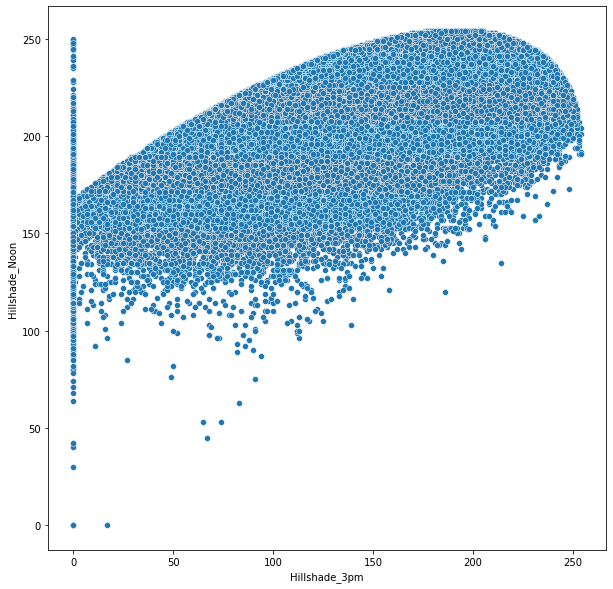

In [ ]:
plt.figure(figsize=(10,10))

sns.scatterplot(data=covtype_pandas, x="Hillshade_3pm", y="Hillshade_Noon")

In [ ]:
import pyspark.sql.functions as f

covtype_pandas = covtype_pandas[covtype_pandas.Hillshade_3pm > 0]
covtype_pandas = covtype_pandas[covtype_pandas.Hillshade_Noon > 120]
covtype_df_s = covtype_df_s.filter((f.col("Hillshade_3pm") > 0) & (f.col("Hillshade_Noon") > 120))

In the following picture we can see the same scatterplot, now filtered. We can easily see how this data makes more sense. 

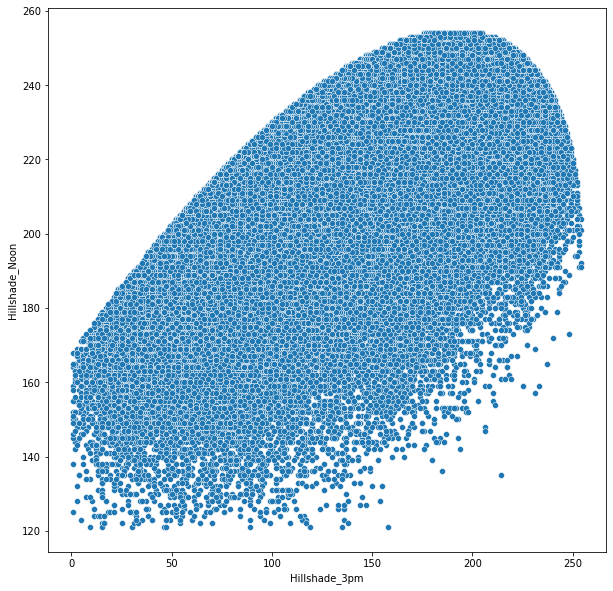

In [ ]:
plt.figure(figsize=(10,10))

sns.scatterplot(data=covtype_pandas, x="Hillshade_3pm", y="Hillshade_Noon")


In the following picture we're going to see if the Hillshade_9am has some outliers or not. We can set a bound right in 50 to filter out those that doesn't make sense:

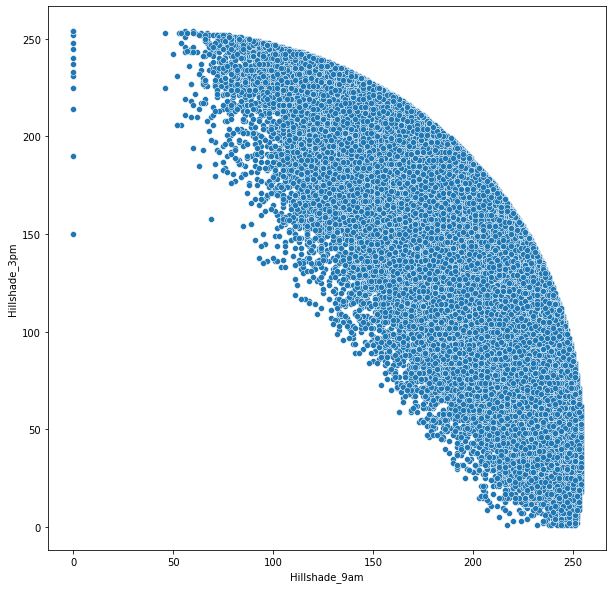

In [ ]:
plt.figure(figsize=(10,10))

sns.scatterplot(data=covtype_pandas, x="Hillshade_9am", y="Hillshade_3pm")


In [ ]:
covtype_pandas = covtype_pandas[covtype_pandas.Hillshade_9am > 50]
covtype_df_s = covtype_df_s.filter(covtype_df_s['Hillshade_9am'] > 50)

Here we can see our sanitized scatterplot:

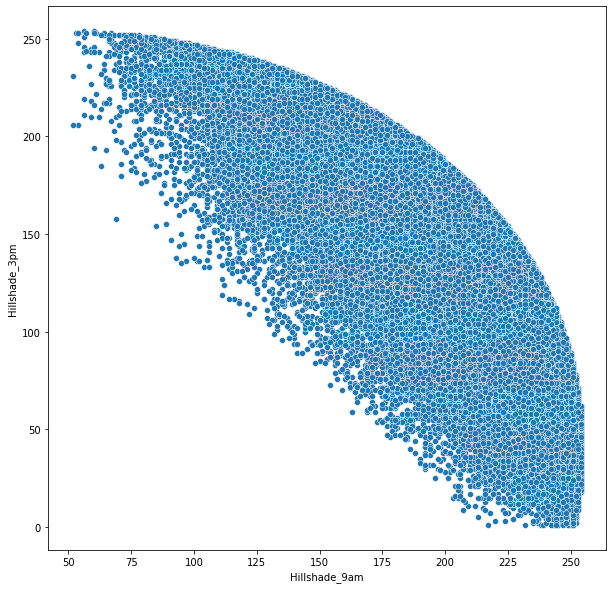

In [ ]:
plt.figure(figsize=(10,10))

sns.scatterplot(data=covtype_pandas, x="Hillshade_9am", y="Hillshade_3pm")

Here we can see the relationship between vertical and horizontal distance to hydrology, which actually makes even more sense to show the computed distance using both of them, but this works for detecting and removing undesired outliers. We can see how we end up having negative vertical distance which actually doesn't make any sense. Distance is positive definite, we've decided to work just with positive distances. 

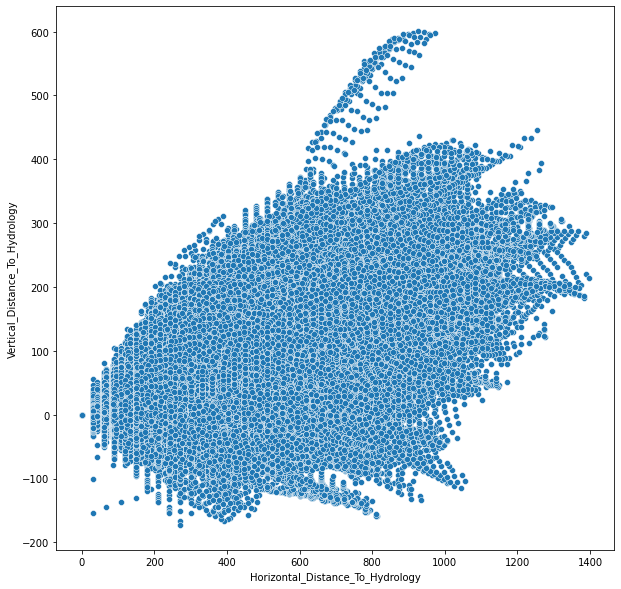

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=covtype_pandas, x="Horizontal_Distance_To_Hydrology", y="Vertical_Distance_To_Hydrology")

In [ ]:
covtype_pandas = covtype_pandas[covtype_pandas.Horizontal_Distance_To_Hydrology > 0]
covtype_pandas = covtype_pandas[covtype_pandas.Vertical_Distance_To_Hydrology > 0]
covtype_df_s = covtype_df_s.filter((f.col("Horizontal_Distance_To_Hydrology") > 0) & (f.col("Vertical_Distance_To_Hydrology") > 0))

The following chart shows the relationship between these variables, which we'll clearly see when we compute the overall euclidean like distance:

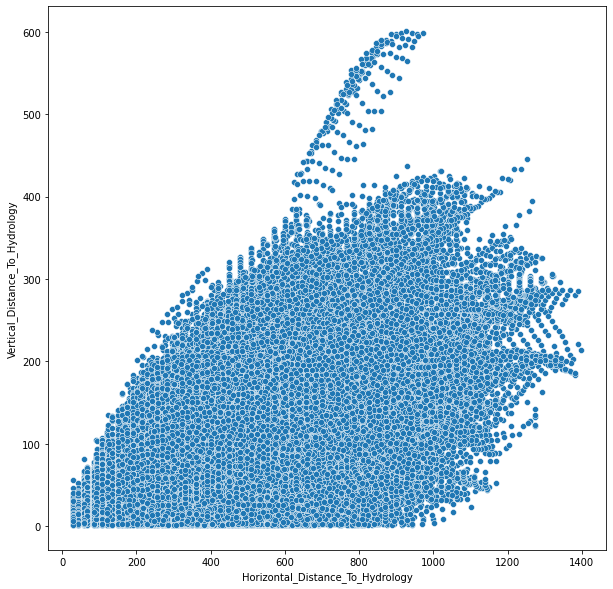

In [ ]:
plt.figure(figsize=(10,10))

sns.scatterplot(data=covtype_pandas, x="Horizontal_Distance_To_Hydrology", y="Vertical_Distance_To_Hydrology")


In the following chart we can see how the horizontal distance to roadways grows as elevation tends to be higher. We've decided to work with these values since we think there isn't any weird or non sense data.

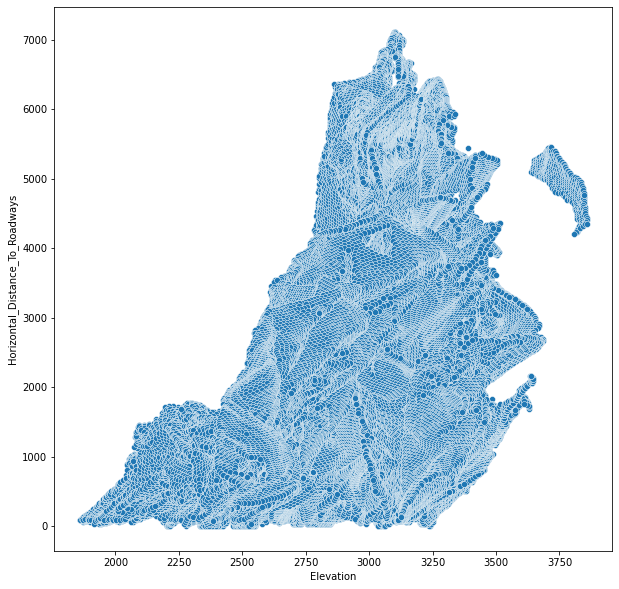

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=covtype_pandas, x="Elevation", y="Horizontal_Distance_To_Roadways")
plt.show()

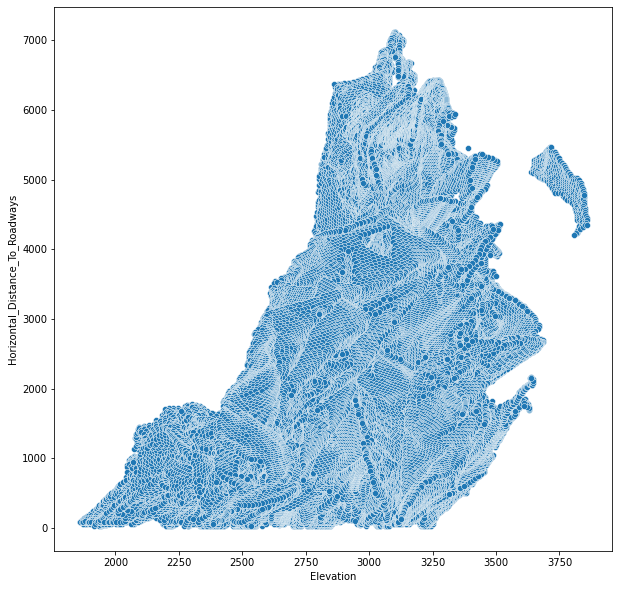

In [ ]:
plt.figure(figsize=(10,10))
covtype_pandas = covtype_pandas[covtype_pandas.Horizontal_Distance_To_Roadways > 0]
covtype_df_s = covtype_df_s.filter(covtype_df_s['Horizontal_Distance_To_Roadways'] > 0)
sns.scatterplot(data=covtype_pandas, x="Elevation", y="Horizontal_Distance_To_Roadways")
plt.show()

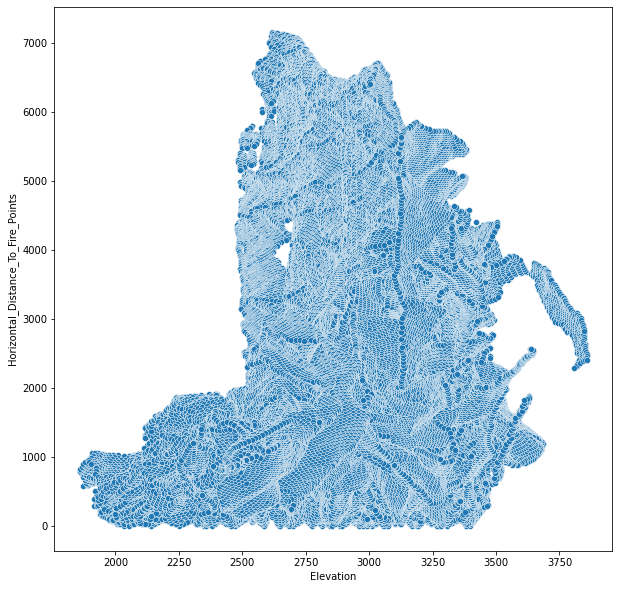

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=covtype_pandas, x="Elevation", y="Horizontal_Distance_To_Fire_Points")
plt.show()

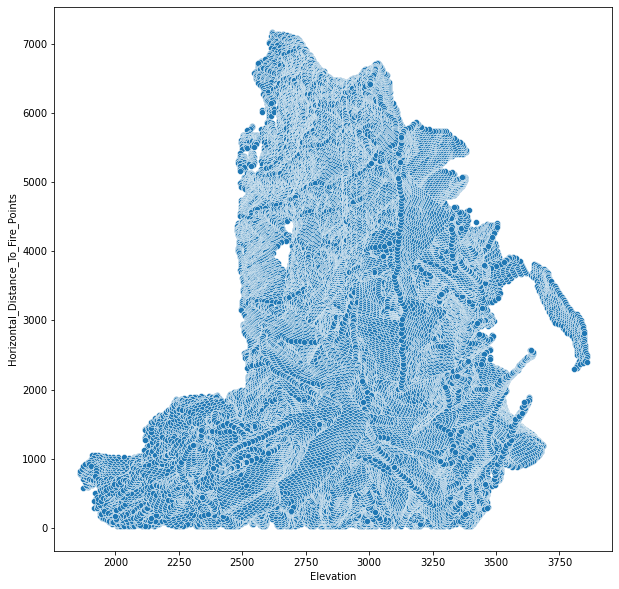

In [ ]:
plt.figure(figsize=(10,10))
covtype_pandas = covtype_pandas[covtype_pandas.Horizontal_Distance_To_Fire_Points > 0]
covtype_df_s = covtype_df_s.filter(covtype_df_s['Horizontal_Distance_To_Fire_Points'] > 0)
sns.scatterplot(data=covtype_pandas, x="Elevation", y="Horizontal_Distance_To_Fire_Points")
plt.show()

Now we're going to switch to a boxplot which is also a really interesting and powerful tool to detect outliers. In this case we're going to see whether aspect feature has outliers. As we can see down below there aren't. We won't do anything to this column.

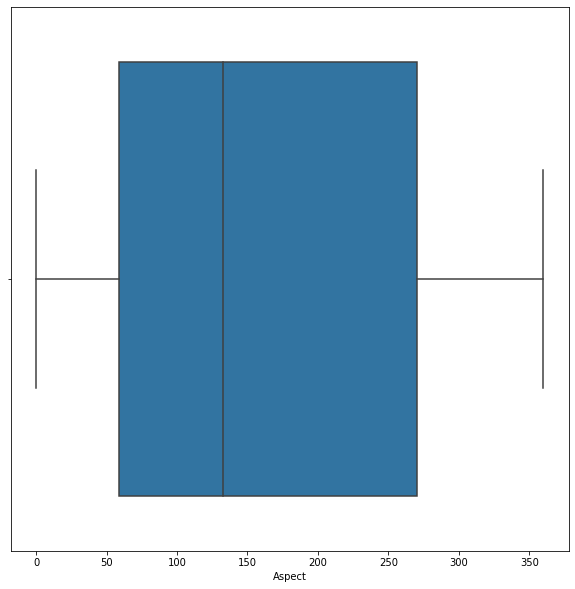

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(covtype_pandas['Aspect'])
plt.show()

We do the same with the slope feature to see if we manage to detect some outliers to get rid of. Actually we have a few of them with values higher than the upper whisker so we need to filter these out. We could even go more strict since our median is still far off from this and even our third quartile but for now on we're going to filter just these:

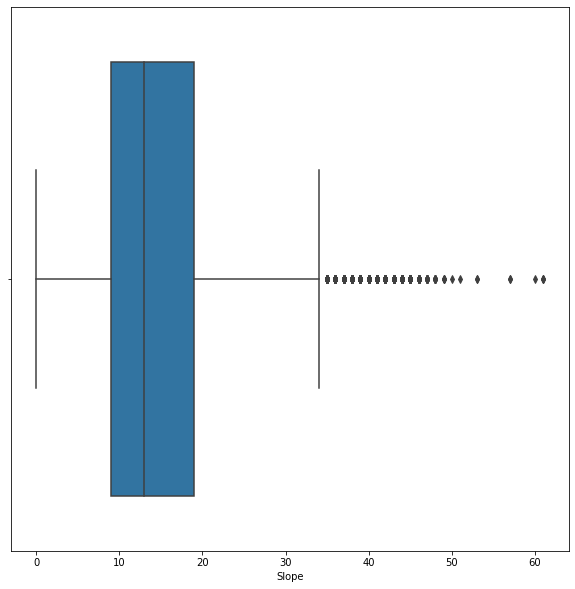

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(covtype_pandas['Slope'])
plt.show()

Here we can see the same boxplot without the outliers:

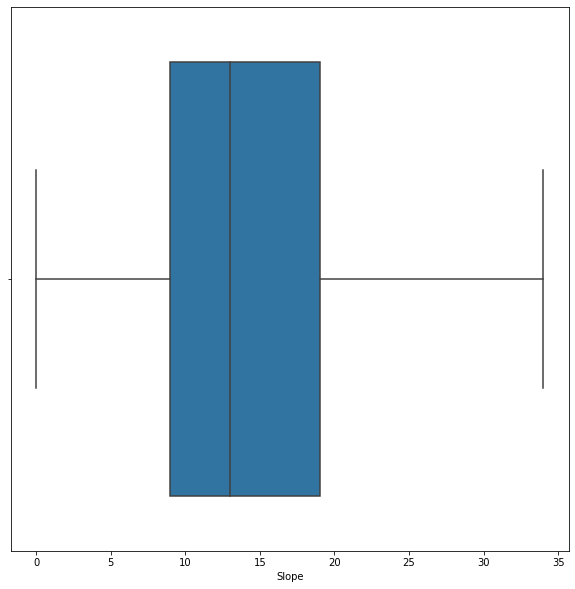

In [ ]:
covtype_pandas = covtype_pandas[covtype_pandas.Slope < 35]
covtype_df_s = covtype_df_s.filter(covtype_df_s['Slope'] < 35)
plt.figure(figsize=(10,10))
sns.boxplot(covtype_pandas['Slope'])
plt.show()

### 3. EDA

We're going to start off this section by showing the correlation values between the different features and cover_type which is actually what we intend to predict in this lab. Some of the features seem to be relatively important and have a fairly considerable correlation value such as the Wilderness_Area4 and some of the soil type columns, Soil_Type10 for instance. Other columns such as Slope with a positive correlation or elevation and horizontal_distance_to_roadways with a negative correlation which basically means that when these increase the other decreases. We'll see if later on these features are still the most important ones...

In [ ]:
(covtype_pandas.corr()[["Cover_Type"]].sort_values(by="Cover_Type",ascending=False).style.background_gradient(cmap="rainbow", axis=None))

Now we're going to see a correlation matrix between all features except the soil_type ones since these are binary and we won't be doing any kind of operations between them, we'll discuss later on different ways to group them to generate some potential relevant features but for now we're going to focus our attention on those features that are continuous and may be used to compute a new feature as an operation between any of these.

All of these features are pretty interesting, we see some fairly strong correlations both positive and negative. We could compute the distance to hydrology given the vertical and horizontal distances and we could even calculate the distance between elevation and the vertical distance to hydrology, this could be also an interesting feature to play with. 

In [ ]:
(covtype_pandas.corr().loc[[i for i in covtype_pandas.columns if i not in ['Soil_Type'+str(n) for n in range(1,41)]], [i for i in covtype_pandas.columns if i not in ['Soil_Type'+str(n) for n in range(1,41)]]].style.background_gradient(cmap="rainbow", axis=None))

Here we can get an idea of how the different cover_types are distributed. This histogram shows that the most common cover_type is 2 followed by 1 and the least common would be 4. 

Cover_Types:

1.   Lodgepole Pine
2.   Ponderosa Pine
3.   Cottonwood/Willow
4.   Aspen
5.   Douglas-fir
6.   Krummholz


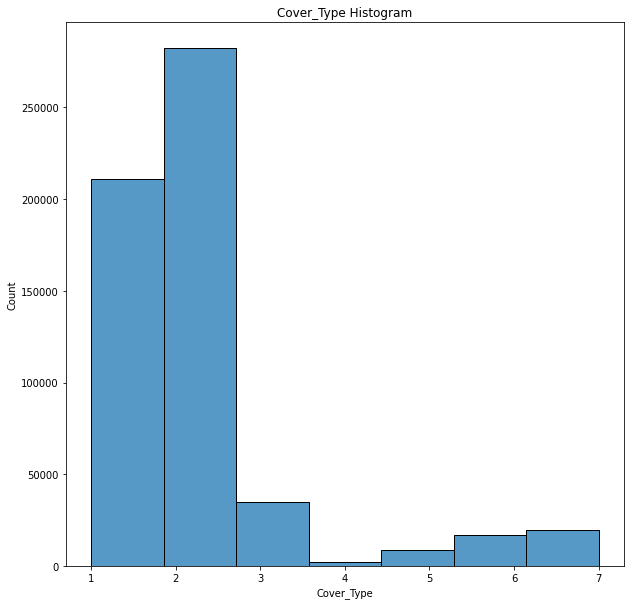

In [ ]:
plt.figure(figsize=(10,10))
sns.histplot(data=covtype_pandas, x="Cover_Type", bins=7)
plt.title("Cover_Type Histogram")
plt.show()

In the following chart we're showing how the distance is distributed in our dataset. Most of our entries have a distance between 100 and 400 meters.

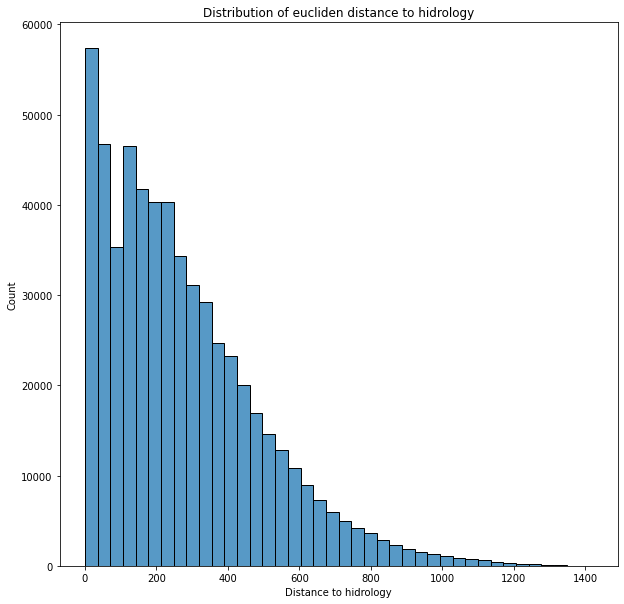

In [ ]:
plt.figure(figsize=(10,10))
sns.histplot(data=((covtype_pandas["Horizontal_Distance_To_Hydrology"]**2 + covtype_pandas["Vertical_Distance_To_Hydrology"]**2)**0.5), bins=40)
plt.title("Distribution of eucliden distance to hidrology")
plt.xlabel("Distance to hidrology")
plt.show()

In the next chart we see how the soil_type10 is distributed among the different cover_types by showing the density evolution. We can see that this particular soil (Bullwark-Catamount family) is mostly present in cover_types 2, 3 and 6 (lodgepole pine, ponderosa pine and douglas-fir respectively).

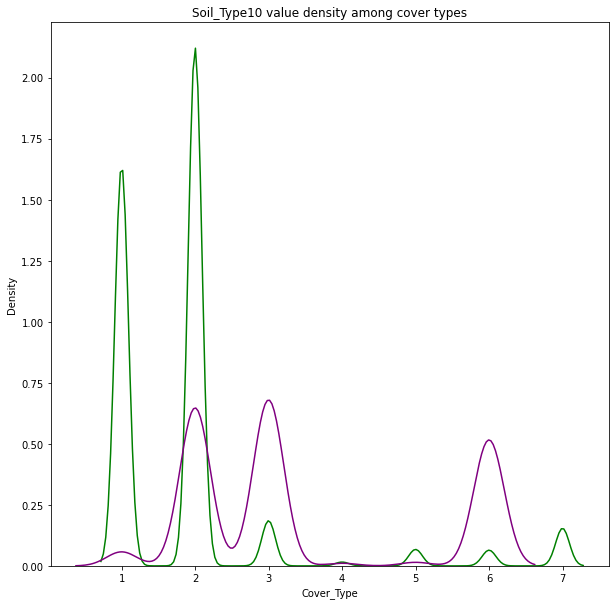

In [ ]:
plt.figure(1, figsize=(10,10))


sns.kdeplot(covtype_pandas.loc[covtype_pandas["Soil_Type10"] == 0, "Cover_Type"], label="Soil_Type10 = 0", color="green")
sns.kdeplot(covtype_pandas.loc[covtype_pandas["Soil_Type10"] == 1, "Cover_Type"], label="Soil_Type10 = 1", color="purple")
plt.title("Soil_Type10 value density among cover types")
plt.show()

In this chart we show how the Wilderness_Area3 density value is distributed among the cover_type classes. We can see that this particular wilderness area (comanche peak)  is quite common among all these types, being particularly present in the lodgepole pine cover type. This does not polarize our cover_types, which means that doesn't define pretty well any of them.

We could go on and on printing the same graph for different wilderness and soil type columns to see how these are distributed among the different classes but actually we're not that interested in getting to know this particular information since we don't have any kind of background in this field. Nevertheless is quite curious to check this information by googling it and indeed, we've confirmed that this information actually makes sense.

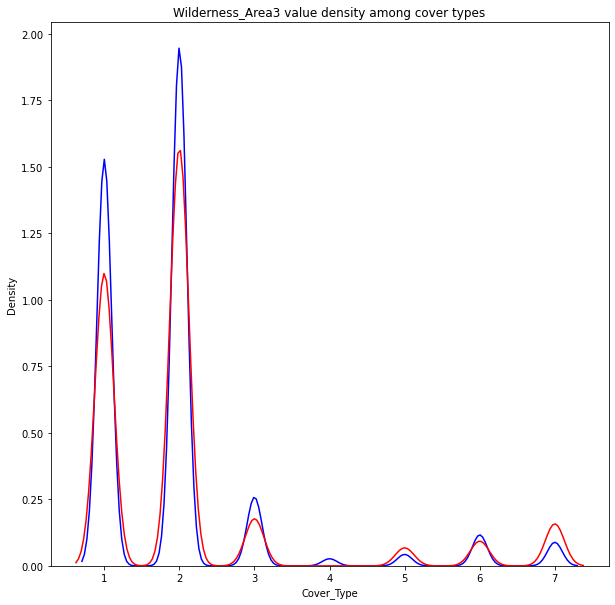

In [ ]:
plt.figure(1, figsize=(10,10))


sns.kdeplot(covtype_pandas.loc[covtype_pandas["Wilderness_Area3"] == 0, "Cover_Type"], label="Wilderness_Area3 = 0", color="blue")
sns.kdeplot(covtype_pandas.loc[covtype_pandas["Wilderness_Area3"] == 1, "Cover_Type"], label="Wilderness_Area3 = 1", color="red")
plt.title("Wilderness_Area3 value density among cover types")
plt.show()

Now we're going to show how the horizontal distance to roadways is distributed among the cover  types. We can clearly see that the Cottonwood one is the closest one and Krummholz would probably be the farthest one.

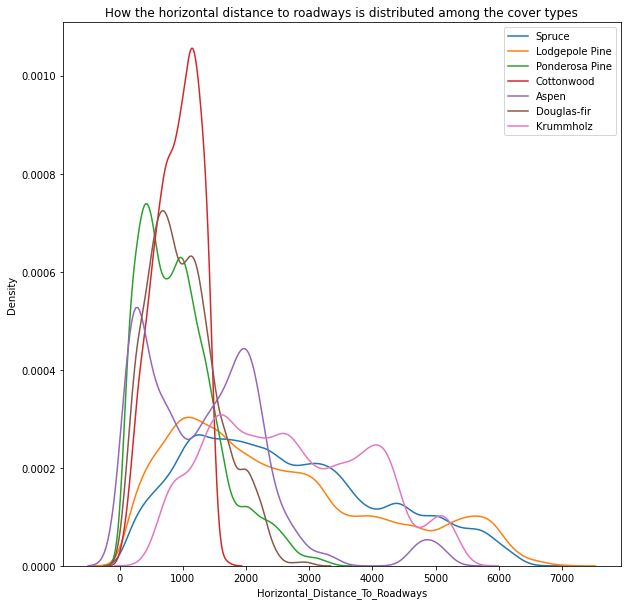

In [ ]:
ll_type = ['Spruce', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood', 'Aspen', 'Douglas-fir', 'Krummholz']

plt.figure(1, figsize=(10,10))
for i, cover_type in enumerate(ll_type):
  sns.kdeplot(covtype_pandas.loc[covtype_pandas["Cover_Type"] == i+1, "Horizontal_Distance_To_Roadways"], label=cover_type)
plt.legend(loc="best")
plt.title("How the horizontal distance to roadways is distributed among the cover types")
plt.show()

Now we do a litle bit of knowledge domain feature creation by adding a new column that will contain the distance to hydrology by using both horizontal and vertical distance to hydrology. This feature could be a really good candidate for the Feature Engineering section we'll discuss later on.

In [ ]:
import numpy as np

covtype_pandas['Distance_To_Hydrology'] = covtype_pandas.apply(lambda row: np.sqrt((row.Horizontal_Distance_To_Hydrology)**2 + (row.Vertical_Distance_To_Hydrology)**2), axis=1)
covtype_df_s = covtype_df_s.withColumn('Distance_To_Hydrology', (covtype_df_s.Horizontal_Distance_To_Hydrology**2 + (covtype_df_s.Vertical_Distance_To_Hydrology)**2)**.5)


Once we've created the distance to hydrology column we're going to show the distance to hydrology per cover type. The closest ones are both Cottonwood and Douglas-fir. The farthest seems to be Krummholz once again.

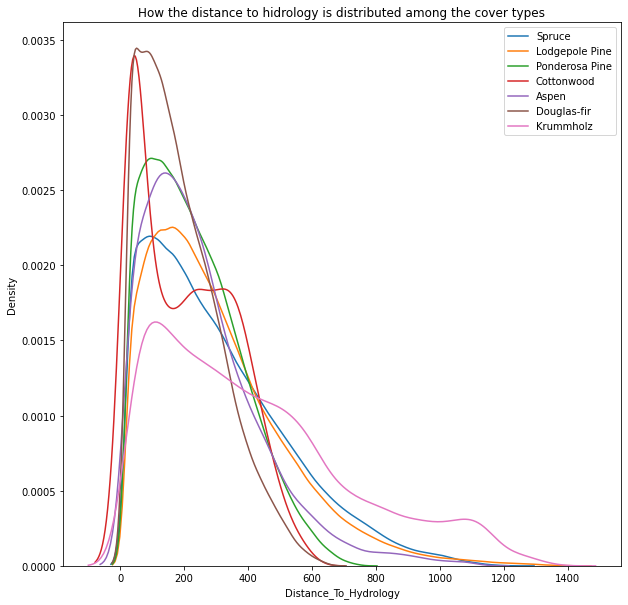

In [ ]:
plt.figure(1, figsize=(10,10))
for i, cover_type in enumerate(ll_type):
  sns.kdeplot(covtype_pandas.loc[covtype_pandas["Cover_Type"] == i+1, "Distance_To_Hydrology"], label=cover_type)
plt.legend(loc="best")
plt.title("How the distance to hidrology is distributed among the cover types")
plt.show()

Now we're curious to see how the correlations might be with this new feature. We see that between this feature and cover_type there's little interaction as far as correlation goes. Something interesting is that this new feature has a certain influence over elevation and viceversa. 

In [ ]:
(covtype_pandas.corr()[["Distance_To_Hydrology"]].sort_values(by="Distance_To_Hydrology",ascending=False).style.background_gradient(cmap="rainbow", axis=None))

If we plot both elevation and distance_to_hydrology features we can clearly see that the distance increases as we go higher and higher in elevation. Completely makes sense.

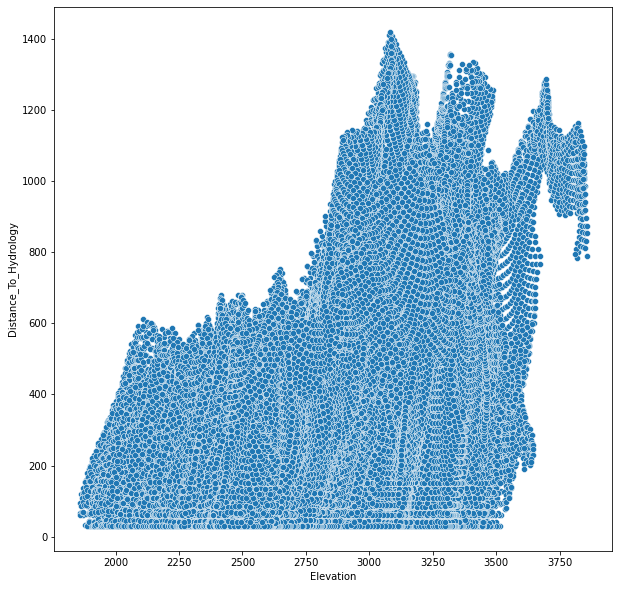

In [ ]:
plt.figure(figsize=(10,10))

sns.scatterplot(data=covtype_pandas, x="Elevation", y="Distance_To_Hydrology")


The next graph will help us to further understand the distribution of the vertical distances to hydrology according to our elevation:

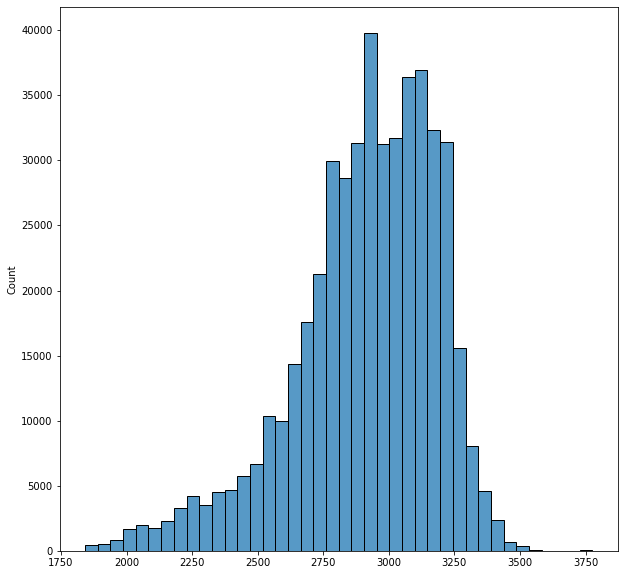

In [ ]:
plt.figure(figsize=(10,10))
sns.histplot(data=(covtype_pandas['Elevation'] - covtype_pandas['Vertical_Distance_To_Hydrology']), bins=40)
plt.show()

### 4. Feature Engineering

### Creating potential knowledge-domain features: 


Here we've decided to create a few knowledge domain features such as the ratio distance to hydrology, the log of the horizontal distance to roadways as our teacher recommended us, the elevation hydrology computed as the difference between elevation and vertical distance to hydrology and last but not least the horizontal distance between hydrology and roads computed as the difference between both of these.

In [ ]:
from pyspark.sql.functions import col, log
import numpy as np

covtype_pandas['Ratio_Distance_To_Hidrology'] = covtype_pandas.apply(lambda row: ((row.Vertical_Distance_To_Hydrology) / (row.Horizontal_Distance_To_Hydrology)), axis=1)
covtype_pandas = covtype_pandas[covtype_pandas.Ratio_Distance_To_Hidrology > 0]

covtype_df_s = covtype_df_s.withColumn('Ratio_Distance_To_Hidrology', (covtype_df_s.Vertical_Distance_To_Hydrology / covtype_df_s.Horizontal_Distance_To_Hydrology))
covtype_df_s = covtype_df_s.filter(covtype_df_s['Ratio_Distance_To_Hidrology'] > 0)


covtype_df_s = covtype_df_s.withColumn("Log_Horizontal_Distance_To_Roadways", log(col("Horizontal_Distance_To_Roadways")))
covtype_df_s = covtype_df_s.filter(covtype_df_s['Log_Horizontal_Distance_To_Roadways'] > 0)
covtype_pandas['Log_Horizontal_Distance_To_Roadways'] = np.log10(covtype_pandas['Horizontal_Distance_To_Roadways'])
covtype_df_s = covtype_df_s.withColumn("Elevation_Hydrology", covtype_df_s["Elevation"] - covtype_df_s["Vertical_Distance_To_Hydrology"])
covtype_pandas['Elevation_Hydrology'] = covtype_pandas['Elevation'] - covtype_pandas['Vertical_Distance_To_Hydrology']
covtype_df_s = covtype_df_s.withColumn("Horizontal_Distances_Hydro_Road", covtype_df_s["Horizontal_Distance_To_Hydrology"] - covtype_df_s["Horizontal_Distance_To_Roadways"])
covtype_pandas['Horizontal_Distances_Hydro_Road'] = covtype_pandas['Horizontal_Distance_To_Hydrology'] - covtype_pandas['Horizontal_Distance_To_Roadways']
covtype_df_s = covtype_df_s.filter(covtype_df_s['Horizontal_Distances_Hydro_Road'] > 0)

new_features = ['Distance_To_Hydrology', 'Log_Horizontal_Distance_To_Roadways', 'Elevation_Hydrology', 'Horizontal_Distances_Hydro_Road']

Now it's interesting to see what happens with the correlations between these newly added features and out cover_type feature:

In [ ]:
correlation_m = covtype_pandas.corr()
correlation_m.loc[['Cover_Type']+new_features, ['Cover_Type']+new_features].style.background_gradient(axis=None)

We can clearly see that the elevation_hydrology and log horizontal distance are promising. We'll see what happens with the second one...

Once we've created these knowledge-domain features now we're going to create both our train and test dataframes with the randomSplit method. In this case we want to create the train_df with the 80% of the data and the test will obtain the other 20%. 

In this case we've decided not to drop the cover_type column from our test_df, even though we know we have to get rid of it once we pass the data to make our predictions and this column is the one we'll be predicting.Nevertheless we need this column to compute different metrics of our model, its actually easier to filter it out later.

In [ ]:
train_df, test_df = covtype_df_s.randomSplit(weights=[0.8,0.2], seed=1)

# test_df = test_df.drop("Cover_Type")

In the following cell we define our standarize_data function that will normalize our features allowing us to work with values in a common scale so that we don't end up distorting differences in the range of values. We'll normalize this data for continuous columns or features such that the distribution resembles a normal distribution.

We could use the StandardScaler that pyspark offers us to actually improve the performance but we wanted to do it by ourselves. In case we want to improve the timing we can always reuse what we have done in other labs to normalize the data, it's rather simple to use what Spark offers us though we think it's also good to do a little bit of recap on these things and manually implement it.

In [ ]:
from pyparsing.util import col
from pyspark.sql.functions import stddev, mean, col



def standarize_data(train_df, test_df, columns=[], ll_saltar=[]):

  for column in columns:
    mean_temp = train_df.select(mean(column)).collect()
    std_temp = train_df.select(stddev(column)).collect()
    train_df = train_df.withColumn('temp_col', (col(column) - mean_temp[0][0]) / std_temp[0][0]).drop(column)
    train_df = train_df.withColumnRenamed('temp_col', column)


    test_df = test_df.withColumn("temp_col", (col(column) - mean_temp[0][0]) / std_temp[0][0]).drop(column)
    test_df = test_df.withColumnRenamed('temp_col', column)
    

  return train_df, test_df

ll_cols_sta = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", "Hillshade_9am", "Hillshade_Noon", 
               "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points", 'Distance_To_Hydrology', 'Ratio_Distance_To_Hidrology', 'Log_Horizontal_Distance_To_Roadways', 'Elevation_Hydrology', 'Horizontal_Distances_Hydro_Road']

train_df, test_df = standarize_data(train_df, test_df, ll_cols_sta)


train_df.summary().show()

+-------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------------------+-------------------+----------+----------+--------------------+-------------------+-------------------+--------------------+--------------------+-----------+-----------+--------------------+--------------------+-----------+--------------------+--------------------+-----------+-------------------+-------------------+--------------------+-------------------+-----------+-----------+-----------+--------------------+--------------------+-------------------+-------------------+-------------------+-----------+-----------+-----------+-----------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------------------+------------------------------+-------------------------------+--------------------+----

Different ways to group soil type:
- According to climatic zones
- According to geologic zones
- According to the geographic zone (rocky, rubbly, others)
- Soil Family

We'll create the dictionaries where we'll specify which soil_type columns represent any of the climatic_zones, geologic_zones or others. Depending on the type and number of agroupations we want to evaluate our model on we'll have to execute one, all or none of the following 4 cells:

In [ ]:
dic_clim_zone = {'lower_montane': [i for i in range(1, 7)], 'montane_dry': [7,8], 'montane': [i for i in range(9, 14)], 'mon_dry_and_mon': [14, 15], 'montane_and_subalpine': [16,17,18], 
           'subalpine': [i for i in range(19, 35)], 'alpine': [i for i in range(35, 41)]}
geologic_zones = {'alluvium': [14, 15, 16, 17, 19, 20, 21], 'glacial': [9, 22, 23], 'mixed_sedimentary': [7, 8], 'igneous_and_metamorphic': [1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 18, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]}
rel_stone = {'stony': [1,2,6,9,12,18,24,25,26,27,28,29,30,31,32,33,34,36,37,38,39,40], 'rubbly': [3,4,5,10,11,13], 'others':[7,8,14,15,16,17,19,20,21,22,23,35]}
rel_family = {'Ratake': [2,4], 'Vanet':[2,5,6], 'Catamount':[10,11,13,26,31,32,33], 'Leighan':[22,23,24,25,27,28,31,33,38], 'Bullwark':[10,11], 'Como':[29,30], 'Moran':[38,39,40], 'Other':[1,3,7,8,9,12,14,15,16,17,18,19,20,21,34,35,36,37]}

Grouping the soil_type by climatic zones:

In [ ]:
for key, value in dic_clim_zone.items():
  ll_soil = ["Soil_Type"+str(n) for n in value]
  train_df = train_df.withColumn(key, sum(train_df[col] for col in ll_soil))
  test_df = test_df.withColumn(key, sum(test_df[col] for col in ll_soil))

Grouping the soil_type by geologic_zones:

In [ ]:
for colName, coldIdx in geologic_zones.items():
    ll_soil = ["Soil_Type"+str(n) for n in geologic_zones[colName]]
    test_df = test_df.withColumn(colName, sum(test_df[col] for col in ll_soil))
    train_df = train_df.withColumn(colName, sum(train_df[col] for col in ll_soil))

Grouping the soil_type by the geographic zone (rocky, rubbly, others):

In [ ]:
for key, value in rel_stone.items():
  ll_soil = ["Soil_Type"+str(n) for n in value]
  train_df = train_df.withColumn(key, sum(train_df[col] for col in ll_soil))
  test_df = test_df.withColumn(key, sum(test_df[col] for col in ll_soil))

Grouping our soil_type by the soil family type:

In [ ]:
for key, value in rel_family.items():
  ll_soil = ["Soil_Type"+str(n) for n in value]
  train_df = train_df.withColumn(key, sum(train_df[col] for col in ll_soil))
  test_df = test_df.withColumn(key, sum(test_df[col] for col in ll_soil))

In [ ]:
train_df.summary().show()

+-------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------------------+-------------------+----------+----------+--------------------+-------------------+-------------------+--------------------+--------------------+-----------+-----------+--------------------+--------------------+-----------+--------------------+--------------------+-----------+-------------------+-------------------+--------------------+-------------------+-----------+-----------+-----------+--------------------+--------------------+-------------------+-------------------+-------------------+-----------+-----------+-----------+-----------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------------------+------------------------------+-------------------------------+--------------------+----

After aggroupating the soil_type following certain criteria as we've shown above now we have to decide which columns we remove from our dataset. Most of the time is actually convenient to work with a small number of columns, there's no point keeping all the columns we started with since many of these actually don't carry valuable information for our model to predict new cover_types. Since we've grouped the soil_type following some criteria we'll remove all the soil_type columns, both vertical and horizontal distance to hydrology since we've computed the distance, elevation hydrology and the horizontal distance to hydrology and roadways. We'll also remove both hillshade and wilderness_area columns since these doesn't have a big impact on our predictions as far as we've seen with all the experiments we've performed.

In [ ]:
for i in range(1,41):
  train_df = train_df.drop('Soil_Type'+str(i))
  test_df = test_df.drop('Soil_Type'+str(i))

train_df = train_df.drop("Vertical_Distance_To_Hydrology")
train_df = train_df.drop("Horizontal_Distance_To_Hydrology")

test_df = test_df.drop("Vertical_Distance_To_Hydrology")
test_df = test_df.drop("Horizontal_Distance_To_Hydrology")

train_df = train_df.drop('Hillshade_9am')
train_df = train_df.drop('Hillshade_Noon')
train_df = train_df.drop('Hillshade_3pm')
test_df = test_df.drop('Hillshade_9am')
test_df = test_df.drop('Hillshade_Noon')
test_df = test_df.drop('Hillshade_3pm')

train_df = train_df.drop('Wilderness_Area1')
train_df = train_df.drop('Wilderness_Area2')
train_df = train_df.drop('Wilderness_Area3')
train_df = train_df.drop('Wilderness_Area4')
test_df = test_df.drop('Wilderness_Area1')
test_df = test_df.drop('Wilderness_Area2')
test_df = test_df.drop('Wilderness_Area3')
test_df = test_df.drop('Wilderness_Area4')

After doing this feature extraction and creating new columns we've end up with 19 columns. That's less than half what we initially had (55).

In [ ]:
train_df.summary().show()

+-------+-----------------+--------------------+--------------------+--------------------+-------------------------------+----------------------------------+---------------------+---------------------------+-----------------------------------+--------------------+-------------------------------+--------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+
|summary|       Cover_Type|           Elevation|              Aspect|               Slope|Horizontal_Distance_To_Roadways|Horizontal_Distance_To_Fire_Points|Distance_To_Hydrology|Ratio_Distance_To_Hidrology|Log_Horizontal_Distance_To_Roadways| Elevation_Hydrology|Horizontal_Distances_Hydro_Road|              Ratake|              Vanet|          Catamount|           Leighan|           Bullwark|               Como|              Moran|               Other|
+-------+-----------------+--------------------+--------------------+---------------

### 5. Model Training

Here we define our pipeline to fit our decision tree model which we define right before specifying the labelcolumn and features, setting a maximum depth for this tree and setting also the impurity we want to use (we've also seen that Gini yields really good results as well although not as good as what entropy gives us). It's a really important detail to define the vectorassembler without passing the cover_type column:

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

vector_assembler = VectorAssembler(inputCols=[i for i in train_df.columns if i!="Cover_Type"], outputCol="features")
model = DecisionTreeClassifier(labelCol="Cover_Type", featuresCol="features").setMaxDepth(30).setImpurity("Entropy").setMaxBins(30)
pipeline = Pipeline(stages=[vector_assembler, model])
model = pipeline.fit(train_df)

After defining and fitting our model now it's time to print and show the feature importance that we've obtained. It's curious to see that actually non of the columns that we created grouping the soil type has a significant impact a part from the moran and catamount families, though very little.

What is indeed shocking is how much the elevation_hydrology affects our model, this has almost a 0.43 value in feature importance, which tells us how important it is to our model. This feature actually wasn't in the original dataset nor our teacher has recommended us to implement it. We've created this feature ourselves and it's rather nice to see how we managed to create a really important feature that explains in a great extent how our data behaves. The log of the horizontal distance to roadways actually tells us nothing about the data at all, we could even remove this column since it's pretty useless. Both elevation and horizontal distance to fire points were pretty important as we saw before, and in this case the feature importance of both these features are significant as well, but not as near as elevation_hydrology. 

Elevation  -> 0.09137270864379263
Aspect  -> 0.07708268390063801
Slope  -> 0.02339120300978251
Horizontal_Distance_To_Roadways  -> 0.02736366667083677
Horizontal_Distance_To_Fire_Points  -> 0.08764310277269106
Distance_To_Hydrology  -> 0.04425755619263997
Ratio_Distance_To_Hidrology  -> 0.041890445154591005
Log_Horizontal_Distance_To_Roadways  -> 0.0
Elevation_Hydrology  -> 0.4282529960932749
Horizontal_Distances_Hydro_Road  -> 0.07685940484363733
Ratake  -> 0.006609928084135378
Vanet  -> 0.002039810640113772
Catamount  -> 0.02615023083792863
Leighan  -> 0.012642079066068646
Bullwark  -> 0.0
Como  -> 0.0
Moran  -> 0.054444184089869486
Other  -> 0.0


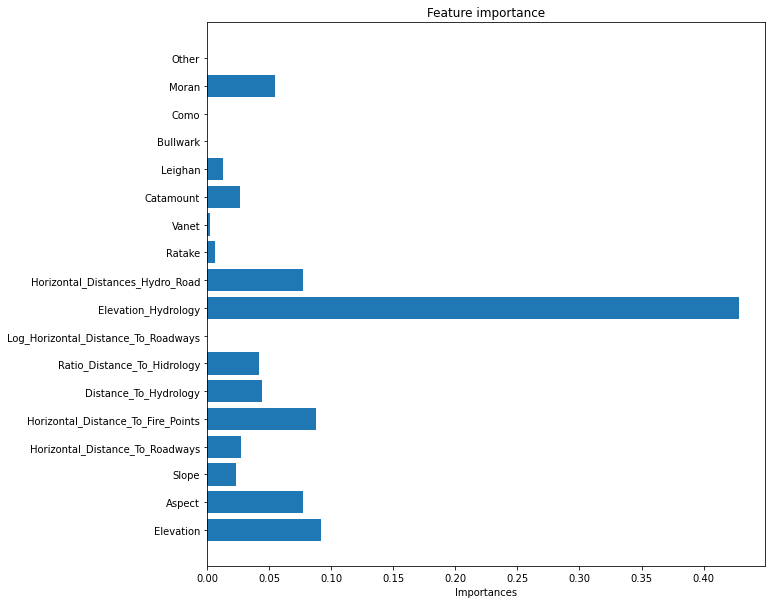

In [ ]:
tree = model.stages[-1]
feature_relevance = tree.featureImportances.toArray()
for col, val in zip([i for i in test_df.columns if i!="Cover_Type"], feature_relevance):
  print(col, " ->", val)  
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(range(len([i for i in test_df.columns if i !="Cover_Type"])), tree.featureImportances.toArray())
ax.set_yticks(range(len([i for i in test_df.columns if i!="Cover_Type"])))
ax.set_yticklabels([i for i in test_df.columns if i!="Cover_Type"])
ax.set_xlabel('Importances')
ax.set_title('Feature importance')
plt.show()

Now we define our random forest model so that we hopefully improve the accuracy of our model. We're going to use the same hyperparameters since we want this comparison to make sense. We're going to produce 8 trees and we'll see whether our accuracy improves or not. 

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

random_forest = RandomForestClassifier(labelCol="Cover_Type", featuresCol="features", numTrees=8).setImpurity("Entropy").setMaxBins(30).setMaxDepth(30)
pipeline_rf = Pipeline(stages=[vector_assembler, random_forest])
model_rf = pipeline_rf.fit(train_df)

### 6. Model evaluation

In [ ]:
predict = model.transform(test_df)
predict_rf = model_rf.transform(test_df)

In the tables shown down below we can see a few predictions of our model, we've got the true label, our prediction and the probability vector which contains (number_of_cov_types_classes + 1) elements. We always end up having an extra element in our probability vector which will be zero. This probability vector tells us the estimated probability that a given input has for each one of the classes. 

In [ ]:
predict.select("Cover_Type", "prediction",  "probability").show(10, truncate=False)

+----------+----------+---------------------------------+
|Cover_Type|prediction|probability                      |
+----------+----------+---------------------------------+
|3         |3.0       |[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0]|
|6         |6.0       |[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]|
|3         |3.0       |[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0]|
|3         |3.0       |[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0]|
|3         |3.0       |[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0]|
|6         |6.0       |[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]|
|6         |6.0       |[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]|
|6         |6.0       |[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]|
|3         |3.0       |[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0]|
|6         |6.0       |[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]|
+----------+----------+---------------------------------+
only showing top 10 rows



In [ ]:
predict_rf.select("Cover_Type", "prediction",  "probability").show(10, truncate=False)

+----------+----------+-----------------------------------------------------------------+
|Cover_Type|prediction|probability                                                      |
+----------+----------+-----------------------------------------------------------------+
|3         |3.0       |[0.0,0.0,0.0,0.9285714285714286,0.0,0.0,0.07142857142857144,0.0] |
|6         |6.0       |[0.0,0.0,0.0,0.14054877081681205,0.0,0.0,0.859451229183188,0.0]  |
|3         |3.0       |[0.0,0.0,0.1,0.9,0.0,0.0,0.0,0.0]                                |
|3         |3.0       |[0.0,0.0,0.0,0.9285714285714286,0.0,0.0,0.07142857142857144,0.0] |
|3         |3.0       |[0.0,0.0,0.2,0.8,0.0,0.0,0.0,0.0]                                |
|6         |6.0       |[0.0,0.0,0.0,0.039732441471571914,0.0,0.0,0.9602675585284282,0.0]|
|6         |6.0       |[0.0,0.0,0.0,0.23858798650308652,0.0,0.0,0.7614120134969135,0.0] |
|6         |6.0       |[0.0,0.0,0.0,0.02434782608695652,0.0,0.0,0.9756521739130435,0.0] |
|3        

In [ ]:
print("REL_FAMILY")
for i in [predict, predict_rf]:
  if i == predict:
    print("DECISION_TREE APPROACH\n")
  else:
    print("RANDOM_FOREST APPROACH\n")
  for j in ["accuracy", "f1"]:
    classifierEvaluator = (MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="Cover_Type",metricName=j))
    print("Showing", j,"-->" ,classifierEvaluator.evaluate(i))
  print()

REL_FAMILY
DECISION_TREE APPROACH

Showing accuracy --> 0.9658323400874056
Showing f1 --> 0.9655511118773756

RANDOM_FOREST APPROACH

Showing accuracy --> 0.9761620977353993
Showing f1 --> 0.9763248459573061



We've tried to improve the accuracy of our model tuning some hyperparameters but no further improvement has been accomplished by doing so. It's interesting to point out the fact that even without SOIL_TYPE or any other transformation of this column preserving both WILDERNESS and HILLSHADE columns our model yields a 0.9331 accuracy on the DECISION_TREE and 0.9511 on a RANDOM_FOREST. This tells us basically that there is little to no information at all on these columns (transformations of SOIL_TYPE's) for our model to predict a COVER_TYPE based on new inputs, there's no other explanation other than this one. The other columns or attributes (features) such as elevation, elevation_hidrology or horizontal_distance_to_firepoints give much more information to our model to learn effectively so that its predictions approximates better the actual ground truth.

Even though we already know we won't be getting much further transforming the SOIL_TYPE columns we've grouped them following certain criteria as we've described before. Here we show some of the results we've obtained after applying some transformations of the SOIL_TYPE and even mixing some of them which, in some cases, slightly improves the accuracy of our model, though it is actually insignificant.

Results (accuracy) obtained using different grouping techniques for Soil_Type columns:

GEOLOGIC_Z:
Decision Tree = 0.9398 |
Random Forest = 0.9620

**REL_FAMILY:
Decision Tree = 0.9510 |
Random Forest = 0.9653**

REL_STONE:
Decision Tree = 0.9425 |
Random Forest = 0.9638

CLIMATIC_ZONE:
Decision Tree = 0.9425 |
Random Forest = 0.9605

CLIMATIC_Z + REL_FAMILY:
Decision Tree = 0.9517 |
Random Forest = 0.9450

CLIMATIC_Z + REL_STONE:
Decision Tree = 0.9462 |
Random Forest = 0.9565

REL_FAMILY + REL_STONE:
Decision Tree = 0.9509 |
Random Forest = 0.9606

REL_FAMILY + REL_STONE + CLIMATIC_Z +  GEOLOGIC_Z:
Decision Tree = 0.9519 |
Random Forest = 0.9266


Having seen that the most promising results have been produced by the REL_FAMILY aggroupation technique we're now going to see whether the accuracy improves or not by removing either Wilderness_Area, Hillshade columns or both.

REL_FAMILY (NO WILDERNESS_AREA COLUMNS):
Decision Tree = 0.9491 |
Random Forest = 0.9624

REL_FAMILY (NO HILLSHADE COLUMNS):
Decision Tree = 0.9533 |
Random Forest = 0.9672

**REL_FAMILY (NO HILLSHADE NOR WILDERNESS_AREA COLUMNS):
Decision Tree = 0.9658 |
Random_Forest = 0.9761**


So it seems like grouping the soil_type by the rel_family and dropping hillshade and wilderness_area columns is the most feasible option, giving us a 96.58% accuracy with the decision tree approach raising it even further up to a 97.61% when we use a random forest.

## 7ish - More feature selection (extra)

So far we've done a pretty good analysis of our dataset and we've built a model that actually can predict up to a 96-97% the cover_type given the data of all the other relevant features we've selected and built.

Now the point is to show how important is to select just those relevant columns that add relevant information to our model and how can affect irrelevant features to our model's performance. In the graph shown above we can see how relevant are the different features to our model and we've seen that there are 6 of them that don't mean anything to our predictions, in fact, worsens the quality of these.

Now the point is to get rid of these 6 features that doesn't even have a 0.01 relevance value and see what happens with our accuracy or error. These features will be: log_horizontal_distance_to_roadways, como, bullwark, other, vanet and retake. We're going to repeat the same process we've shown above so there's no need to explain anything further:

Elevation  -> 0.09377540208392893
Aspect  -> 0.07674221797159969
Slope  -> 0.024612750506116658
Horizontal_Distance_To_Roadways  -> 0.027926221801147802
Horizontal_Distance_To_Fire_Points  -> 0.08831156462041606
Distance_To_Hydrology  -> 0.0441877186626051
Ratio_Distance_To_Hidrology  -> 0.042217276837877425
Elevation_Hydrology  -> 0.4282529960932749
Horizontal_Distances_Hydro_Road  -> 0.07675230409901342
Catamount  -> 0.030135284168081956
Leighan  -> 0.012642079066068644
Moran  -> 0.054444184089869486


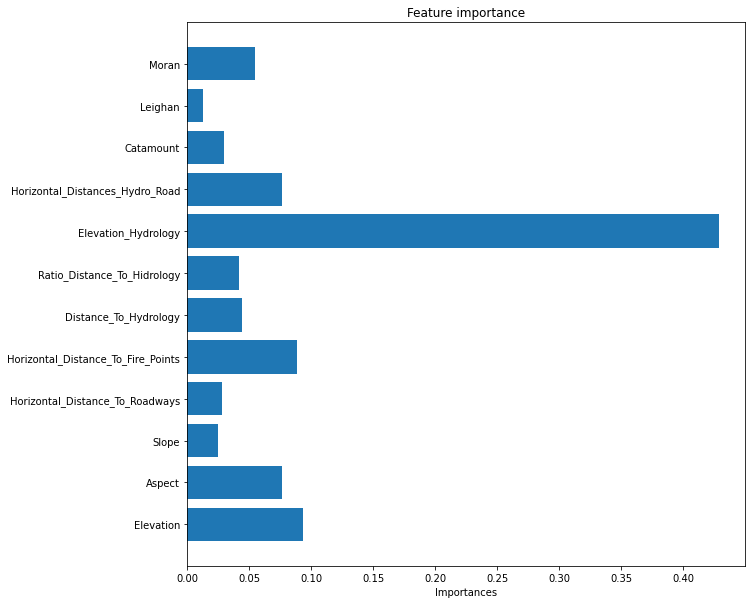

In [ ]:
irrelevant_features = ['Log_Horizontal_Distance_To_Roadways', 'Como', 'Bullwark', 'Other', 'Vanet', 'Ratake']

train_df = train_df.drop(*irrelevant_features)
test_df = test_df.drop(*irrelevant_features)

vector_assembler = VectorAssembler(inputCols=[i for i in train_df.columns if i!="Cover_Type"], outputCol="features")
model = DecisionTreeClassifier(labelCol="Cover_Type", featuresCol="features").setMaxDepth(30).setImpurity("Entropy").setMaxBins(30)
pipeline = Pipeline(stages=[vector_assembler, model])
model = pipeline.fit(train_df)

tree = model.stages[-1]
feature_relevance = tree.featureImportances.toArray()
for col, val in zip([i for i in test_df.columns if i!="Cover_Type"], feature_relevance):
  print(col, " ->", val)  
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(range(len([i for i in test_df.columns if i !="Cover_Type"])), tree.featureImportances.toArray())
ax.set_yticks(range(len([i for i in test_df.columns if i!="Cover_Type"])))
ax.set_yticklabels([i for i in test_df.columns if i!="Cover_Type"])
ax.set_xlabel('Importances')
ax.set_title('Feature importance')
plt.show()

Once we've shown the graph once again for these features without the irrelevant ones now we're going to train and validate our model and we'll see what happens with the accuracy:

In [ ]:
random_forest = RandomForestClassifier(labelCol="Cover_Type", featuresCol="features", numTrees=8).setImpurity("Entropy").setMaxBins(30).setMaxDepth(30)
pipeline_rf = Pipeline(stages=[vector_assembler, random_forest])
model_rf = pipeline_rf.fit(train_df)

predict = model.transform(test_df)
predict_rf = model_rf.transform(test_df)

print("REL_FAMILY")
for i in [predict, predict_rf]:
  if i == predict:
    print("DECISION_TREE APPROACH\n")
  else:
    print("RANDOM_FOREST APPROACH\n")
  for j in ["accuracy", "f1"]:
    classifierEvaluator = (MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="Cover_Type",metricName=j))
    print("Showing", j,"-->" ,classifierEvaluator.evaluate(i))
  print()

REL_FAMILY
DECISION_TREE APPROACH

Showing accuracy --> 0.9670242352006356
Showing f1 --> 0.9667490297489117

RANDOM_FOREST APPROACH

Showing accuracy --> 0.9805323798172427
Showing f1 --> 0.9805122422778874



Indeed, the accuracy has improved after removing useless and irrelevant features. Now we see how the decision tree gives us an accuracy of 96.70% and the random forest approach now reaches the 98% for the first time. We're sure that this has improved the model since after several training-validation runs we easily reach a 98% in the random_forest approach, never obtained before without getting rid of these irrelevant features. 

We have to keep in mind that the feature engineering process may take some iterations to complete and it's perfectly fine to do so, indeed, it is recommended to first try our model preserving some features and afterwards seeing what happens when we do feature selection. Most of the time we'll end up removing several features that doesn't mean anything to our model. Another important fact to keep in mind is that, in most cases, we will be responsibles of computing or generating a new feature as an aggregate of others or aggrupating some of them following certain criteria, and these might be the really outstanding features for our model to improve drastically. It all depends on the problem we're dealing with, but the key point here is that we have to invest as many time as possible in the EDA and feature selection processes. These are key for a really good analysis!